In [21]:
"""
This file makes calls to functions in the michael_morris_github_code folder.
"""

import sys
sys.path.append("./../common/")
from utils import *
sys.path.append("./../michael_morris_github_code/")
from NNs import *
from DataConstructor import *

figures_dir = "../../dump/"
data_type = 'generated'
filename = 'generated_linear'

In [22]:
# optimised hyperparameters
optimised = {'epochs': 422.52120481785863, 'kl_power': -1.2257632479674228, 'lr_power': -2.7726243513776367, 'op_scale': 0.0594300340440397, 'prior_scale': 0.5984203132113145, 'q_scale': 0.06420317334298208, 'rnn_units': 35.84385754392759}

irnn_type = FIB_RNN
batch_size=32

if irnn_type.loss == "EDL":
    optimised["kl_power"] = None
    optimised["op_scale"] = None
    optimised["prior_scale"] = None
    optimised["q_scale"] = None
else:
    optimised['edl_coeff'] = None

gammas = [7,14,21,28]
test_seasons = [2015,2016,2017,2018]
models = {}

for gamma in gammas:
    _data = DataConstructor(gamma=gamma)
    x_train, y_train, x_test, y_test = _data(data_type, filename=filename)
    irnns = FI_NNs(rnn_units=optimised['rnn_units'], kl_power=optimised['kl_power'], op_scale=optimised['op_scale'], prior_scale=optimised['prior_scale'], q_scale=optimised['q_scale'], gamma=gamma, lr_power=optimised['lr_power'], n_batches=int(len(y_train)/batch_size), irnn_type=irnn_type, edl_coeff=optimised['edl_coeff'])
    history = irnns.train(x_train, y_train, epochs=int(optimised['epochs']), verbose=False)
    print(history)

    models[str(gamma)] = irnns

[-2.7039976119995117, -2.7421391010284424, -2.7302067279815674, -2.7395410537719727, -2.728347063064575, -2.715991258621216, -2.7399702072143555, -2.731659412384033, -2.7380244731903076, -2.738945484161377]
[-2.7165398597717285, -2.6989028453826904, -2.7336578369140625, -2.714266300201416, -2.704618453979492, -2.712787389755249, -2.7179205417633057, -2.729735851287842, -2.737182855606079, -2.7151174545288086]
[-2.7404017448425293, -2.7242753505706787, -2.6959307193756104, -2.7085471153259277, -2.7435455322265625, -2.708198308944702, -2.723538875579834, -2.709124803543091, -2.706822395324707, -2.7125391960144043]
[-2.726759433746338, -2.7094690799713135, -2.712545156478882, -2.7181429862976074, -2.7037250995635986, -2.6756722927093506, -2.704641342163086, -2.727952241897583, -2.694180965423584, -2.7165188789367676]


7
7 2015
LEN 10
7  diffs  [0.0021694358]
7  diffs  [0.0018267282]
7  diffs  [0.0019206273]
7  diffs  [0.0023746465]
7  diffs  [0.0022218614]
7  diffs  [0.0020976271]
7  diffs  [0.0028900371]
7  diffs  [0.0019011494]
7  diffs  [0.00243034]
7  diffs  [0.0019151788]
7 2016
LEN 10
7  diffs  [0.0025974344]
7  diffs  [0.0019733324]
7  diffs  [0.0020412349]
7  diffs  [0.0020911226]
7  diffs  [0.0025557578]
7  diffs  [0.0022424273]
7  diffs  [0.0018022856]
7  diffs  [0.0023049053]
7  diffs  [0.0019991589]
7  diffs  [0.0021273112]
7 2017
LEN 10
7  diffs  [0.0018628436]
7  diffs  [0.0021552125]
7  diffs  [0.0024976376]
7  diffs  [0.0020464917]
7  diffs  [0.002368223]
7  diffs  [0.0019860554]
7  diffs  [0.0022536877]
7  diffs  [0.0017482686]
7  diffs  [0.0016951882]
7  diffs  [0.0026596752]
7 2018
LEN 10
7  diffs  [0.0024855172]
7  diffs  [0.002177788]
7  diffs  [0.0022309555]
7  diffs  [0.0021511086]
7  diffs  [0.002552251]
7  diffs  [0.0021500313]
7  diffs  [0.0021416133]
7  diffs  [0.002163898

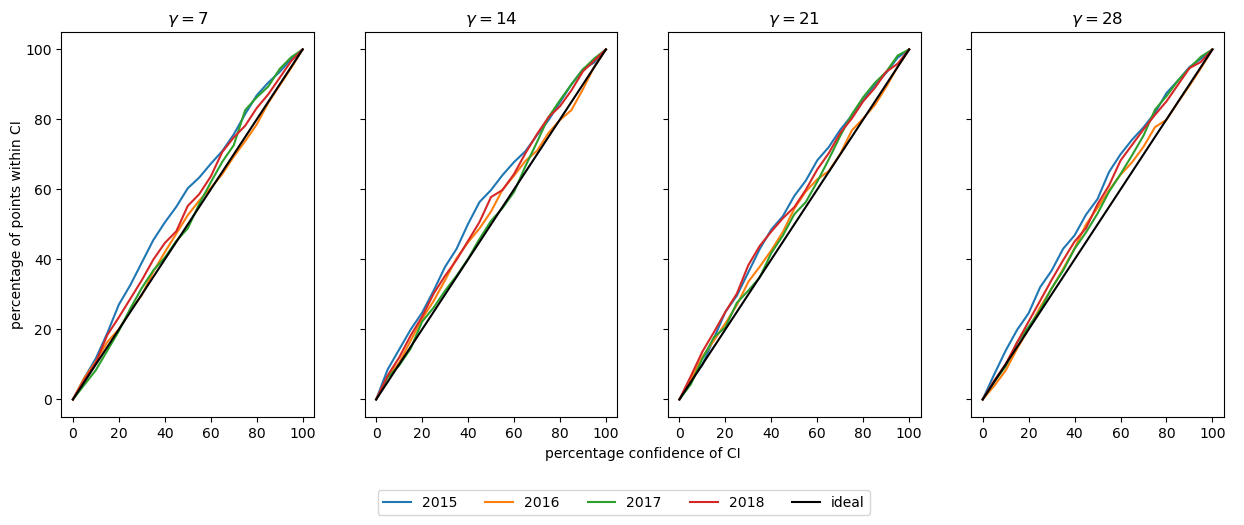

In [23]:
def gamma_data(array, gamma):
    if type(array) != type(np.array([])):
        array = array._numpy()
    return array.flatten()[:len(array)-gamma]

fig, axs = plt.subplots(1, len(models), figsize=(15, 5), sharey=True)
idx = 0

calibrations = {}
predictions = {}
Y_HAT, SD_HAT, MODEL_UNC, DATA_UNC = 0, 1, 2, 3
for gamma, model in models.items():
    calibrations[gamma] = {}
    predictions[gamma] = {}

confidences = get_confidence_axis()
for gamma, model in models.items():
    print(gamma)
    gamma_str = gamma
    gamma = int(gamma)

    for season in test_seasons:
        print(gamma, season)
        season_str = str(season)
        _data = DataConstructor(test_season=season, gamma=gamma)
        _, _, x_test, y_test = _data(data_type, filename=filename)
        predictions[gamma_str][season_str] = model.get_predictions(x_test, stable=True)
        in_range = unc_calibration(gamma_data(y_test[:,-1:,:], gamma), gamma_data(predictions[gamma_str][season_str][Y_HAT][:,-1:,:], gamma), gamma_data(predictions[gamma_str][season_str][SD_HAT][:,-1:,:], gamma))
        try:
            axs[idx].plot(confidences, in_range, label=str(season))
        except:
            print('in except')
            axs[idx].plot(confidences, in_range[1], label=str(season))
        calibrations[gamma_str][season_str] = in_range

    axs[idx].plot([0,100], [0,100], label="ideal", c="black")
    axs[idx].set_title('$\gamma = {}$'.format(gamma))
    idx += 1

save_multiplot_graph(fig, 'percentage confidence of CI', 'percentage of points within CI', figures_dir, 'test.png', test_seasons + ['ideal'])


In [26]:
# graphs on
test_year = 2015
test_gamma = 28
test_gamma_str = str(test_gamma)
test_year_str = str(test_year)

In [33]:
# UNNORMALISING
test_years = ['2015','2016','2017','2018']
for year in test_years:
    for gamma in gammas:
        _data = DataConstructor(gamma=gamma, test_season=int(year))
        _, _, _, y_test = _data(data_type, filename=filename)
        y_test = y_test._numpy()
        for i in range(gamma):
            y_hat = predictions[str(gamma)][year][Y_HAT][:,i,:].flatten()
            predictions[str(gamma)][year][Y_HAT][:,i,:] = rescale_array('y', y_hat, _data.scaler)
            predictions[str(gamma)][year][SD_HAT][:,i,:] = rescale_array('unc', predictions[str(gamma)][year][SD_HAT][:,i,:].flatten(), _data.scaler, y=y_hat)
            predictions[str(gamma)][year][DATA_UNC][:,i,:] = rescale_array('unc', predictions[str(gamma)][year][DATA_UNC][:,i,:].flatten(), _data.scaler, y=y_hat)
            predictions[str(gamma)][year][MODEL_UNC][:,i,:] = rescale_array('unc', predictions[str(gamma)][year][MODEL_UNC][:,i,:].flatten(), _data.scaler, y=y_hat)


(365, 7, 1)
(365, 14, 1)
(365, 21, 1)
(365, 28, 1)


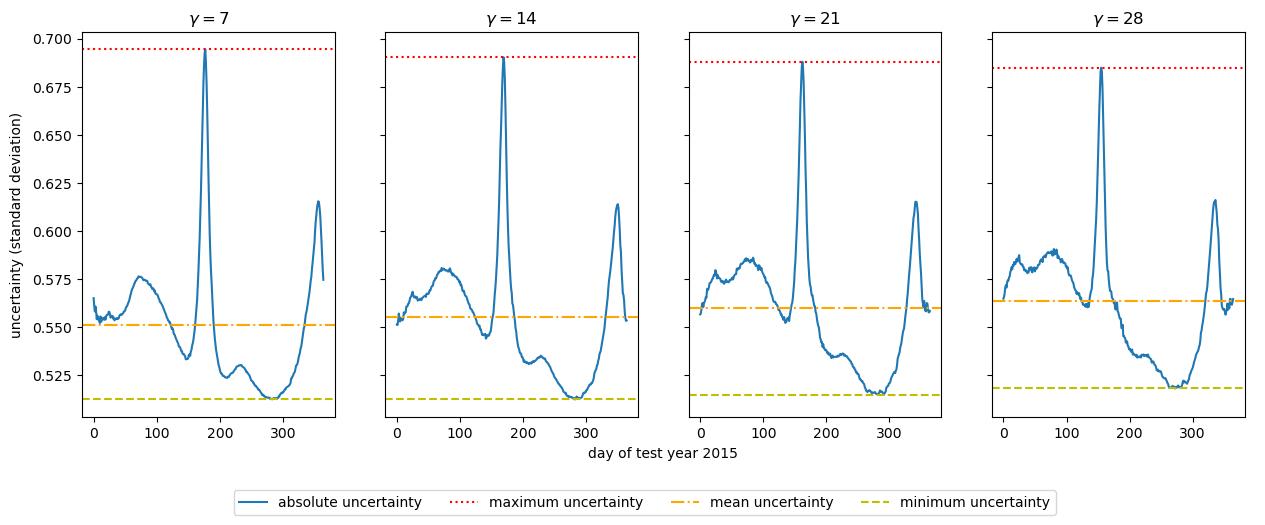

In [61]:
def save_multiplot_graph(fig, x, y, figures_dir, filename, labels=[]):
    if labels:
        artists = (fig.legend(labels, loc='lower center', ncol=len(labels), bbox_transform=fig.transFigure, bbox_to_anchor=[0.5, -0.1]),)
    else:
        artists = ()
    ax = fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(x)
    plt.ylabel(y)
    ax.yaxis.set_label_coords(-0.05, 0.5)
    plt.show()
    fig.savefig(figures_dir + filename, bbox_extra_artists=artists, bbox_inches='tight')

fig, axs = plt.subplots(1, len(models), figsize=(15, 5), sharey=True)
# plt.tight_layout(w_pad=5)
idx = 0
days = np.arange(0,365)
for gamma, prediction in predictions.items():

    print(prediction[test_year_str][SD_HAT].shape)

    sds = prediction[test_year_str][SD_HAT][:,-1:,:].flatten()
    axs[idx].plot(sds)
    axs[idx].axhline(y = np.max(sds), color = 'r', linestyle = ':', label='maximum uncertainty')
    axs[idx].axhline(y = np.mean(sds), color = 'orange', linestyle = '-.', label='mean uncertainty')
    axs[idx].axhline(y = np.min(sds), color = 'y', linestyle = '--', label='minimum uncertainty')
    axs[idx].set_title('$\gamma = {}$'.format(gamma))
    idx += 1

save_multiplot_graph(fig, 'day of test year {}'.format(test_year_str), 'uncertainty (standard deviation)', figures_dir, 'test.png', ['absolute uncertainty', 'maximum uncertainty', 'mean uncertainty', 'minimum uncertainty'])

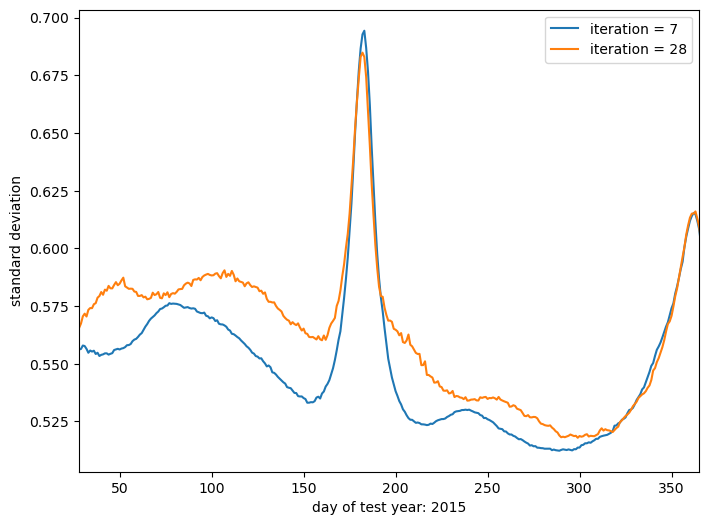

In [35]:
fig = plt.figure()
iterations = [2,7]
# iterations = [1,7,14,28]
iterations = [7,test_gamma]
# iterations = [7,14,21,28,49,56,63,70]
for iteration in range(test_gamma):
    if iteration+1 in iterations:
        plt.plot(np.arange(iteration, 365+iteration),predictions[test_gamma_str][test_year_str][SD_HAT][:,iteration,:].flatten(), label='iteration = {}'.format(iteration+1))

plt.xlim([max(iterations), 365])

save_xy_graph(fig, 'day of test year: {}'.format(test_year_str), 'standard deviation', figures_dir, 'test.png')

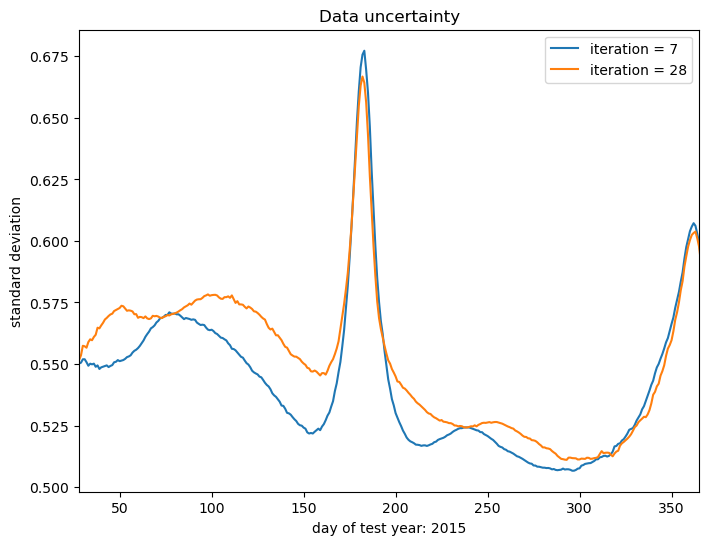

In [38]:
fig = plt.figure()
iterations = [2,7]
# iterations = [1,7,14,28]
iterations = [7,test_gamma]
for iteration in range(test_gamma):
    if iteration+1 in iterations:
        plt.plot(np.arange(iteration, 365+iteration), predictions[test_gamma_str][test_year_str][DATA_UNC][:,iteration,:].flatten(), label='iteration = {}'.format(iteration+1))
plt.title('Data uncertainty')
plt.xlim([max(iterations), 365])
save_xy_graph(fig, 'day of test year: {}'.format(test_year_str), 'standard deviation', figures_dir, 'test.png')

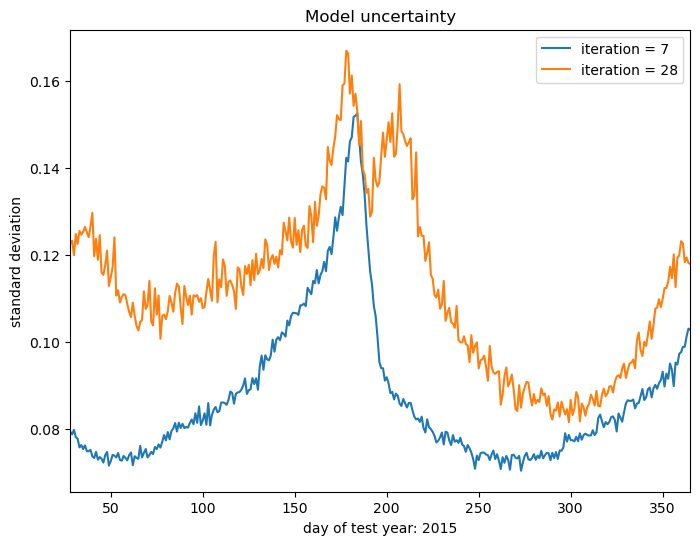

In [39]:
fig = plt.figure()
iterations = [2,7]
# iterations = [1,7,14,28]
iterations = [7,test_gamma]
for iteration in range(test_gamma):
    if iteration+1 in iterations:
        plt.plot(np.arange(iteration, 365+iteration), predictions[test_gamma_str][test_year_str][MODEL_UNC][:,iteration,:].flatten(), label='iteration = {}'.format(iteration+1))
plt.title('Model uncertainty')
plt.xlim([max(iterations), 365])
save_xy_graph(fig, 'day of test year: {}'.format(test_year_str), 'standard deviation', figures_dir, 'test.png')